In [6]:
import torch
import torch.nn as nn
import torch.nn.utils.prune as prune
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import CIFAR10
from torchvision import transforms
import matplotlib.pyplot as plt
from torchmetrics.functional import accuracy
from alexNet_model_train import AlexNetFineTuner
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score 
from torchmetrics.functional import accuracy
import os


In [2]:
# Data transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to 224x224 (AlexNet input size)
    transforms.ToTensor(),          # Convert images to PyTorch tensors
    transforms.Normalize(           # Normalize with ImageNet means and stds
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    ),
])

In [3]:
# Load CIFAR-10 dataset
full_train_dataset = CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = CIFAR10(root='./data', train=False, download=True, transform=transform)

# Split training dataset into train/validation
train_size = int(0.8 * len(full_train_dataset))
val_size = len(full_train_dataset) - train_size
train_dataset, val_dataset = random_split(full_train_dataset, [train_size, val_size])

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=32)
test_dataloader = DataLoader(test_dataset, batch_size=32)

# Set up device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define pruning percentages
pruning_percentages = [0.1, 0.3, 0.5]

Files already downloaded and verified
Files already downloaded and verified


In [4]:
from sklearn.metrics import accuracy_score, f1_score

def evaluate_model(model, dataloader):
    """
    Evaluates the model and returns the accuracy and F1 score.
    """
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            # Forward pass
            outputs = model(inputs)
            preds = torch.argmax(outputs, dim=1)
            
            # Append predictions and labels to lists
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Compute accuracy and F1 score
    accuracy = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average="weighted")

    return accuracy, f1


# Fine-tune model function
def fine_tune_model(model, train_dataloader, val_dataloader, epochs=5, learning_rate=1e-5):
    model.train()
    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
    loss_fn = torch.nn.CrossEntropyLoss()

    for epoch in range(epochs):
        train_loss, train_correct = 0, 0

        # Training loop
        for images, labels in train_dataloader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            train_correct += (outputs.argmax(dim=1) == labels).sum().item()

        # Validation loop
        val_loss, val_correct = 0, 0
        model.eval()
        with torch.no_grad():
            for images, labels in val_dataloader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = loss_fn(outputs, labels)
                val_loss += loss.item()
                val_correct += (outputs.argmax(dim=1) == labels).sum().item()

        train_acc = train_correct / len(train_dataloader.dataset)
        val_acc = val_correct / len(val_dataloader.dataset)

        print(f"Epoch {epoch + 1}/{epochs}, "
              f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

    return model

# Visualize weights function
def visualize_weights(weights, title, save_path="./plots", name="weights.png"):
    out_channels, in_channels, height, width = weights.shape
    n_cols = min(8, out_channels)  # Set the number of columns
    n_rows = (out_channels + n_cols - 1) // n_cols
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 2, n_rows * 2))
    fig.suptitle(title, fontsize=16)
    for i in range(out_channels):
        kernel = weights[i, 0].cpu().detach().numpy()
        ax = axes[i // n_cols, i % n_cols] if n_rows > 1 else axes[i % n_cols]
        ax.imshow(kernel, cmap="gray")
        ax.axis("off")
        ax.set_title(f"Filter {i}")
    for j in range(i + 1, n_rows * n_cols):
        fig.delaxes(axes.flatten()[j])
    plt.tight_layout()
    plt.savefig(f"{save_path}/{name}")
    print(f"Pruned weights visualization saved: {save_path}/{name}")

# Get non-zero indices function
def get_nonzero_indices(model):
    non_zero_indices = {}
    new_channels = {}
    for name, module in model.named_modules():
        if isinstance(module, (nn.Conv2d, nn.Linear)):
            weights = module.weight.data
            indices = [i for i in range(weights.size(0)) if weights[i].abs().sum() > 0]
            normalized_name = name.replace('model.', '')
            non_zero_indices[normalized_name] = indices
            out_channels = len(indices)
            in_channels = weights.size(1) if len(weights.shape) > 2 else weights.shape[0]
            new_channels[normalized_name] = (out_channels, in_channels)
    return non_zero_indices, new_channels

# Create dense model function
def create_dense_model(new_channels):
    class DenseAlexNet(nn.Module):
        def __init__(self):
            super(DenseAlexNet, self).__init__()
            self.features = nn.Sequential(
                nn.Conv2d(3, new_channels["features.0"][0], kernel_size=11, stride=4, padding=2),
                nn.ReLU(inplace=True),
                nn.MaxPool2d(kernel_size=3, stride=2),
                nn.Conv2d(new_channels["features.0"][0], new_channels["features.3"][0], kernel_size=5, padding=2),
                nn.ReLU(inplace=True),
                nn.MaxPool2d(kernel_size=3, stride=2),
                nn.Conv2d(new_channels["features.3"][0], new_channels["features.6"][0], kernel_size=3, padding=1),
                nn.ReLU(inplace=True),
                nn.Conv2d(new_channels["features.6"][0], new_channels["features.8"][0], kernel_size=3, padding=1),
                nn.ReLU(inplace=True),
                nn.Conv2d(new_channels["features.8"][0], new_channels["features.10"][0], kernel_size=3, padding=1),
                nn.ReLU(inplace=True),
                nn.MaxPool2d(kernel_size=3, stride=2)
            )
            self.classifier = nn.Sequential(
                nn.Linear(new_channels["features.10"][0] * 6 * 6, 4096),
                nn.ReLU(inplace=True),
                nn.Dropout(),
                nn.Linear(4096, 4096),
                nn.ReLU(inplace=True),
                nn.Dropout(),
                nn.Linear(4096, 10),
            )

        def forward(self, x):
            x = self.features(x)
            x = x.view(x.size(0), -1)
            x = self.classifier(x)
            return x
    return DenseAlexNet()

# Function to copy weights from pruned to dense model
def copy_weights(pruned_model, dense_model, non_zero_indices):
    for (name, module), (_, dense_module) in zip(pruned_model.named_modules(), dense_model.named_modules()):
        if isinstance(module, nn.Conv2d) or isinstance(module, nn.Linear):
            if name in non_zero_indices:
                indices = non_zero_indices[name]
                for idx_out, idx_in in indices:
                    dense_module.weight.data[idx_out].copy_(module.weight.data[idx_out])
                if module.bias is not None:
                    dense_module.bias.data.copy_(module.bias.data)

# Plotting results
def plot_comparison(val_accuracy, val_f1_score, fine_tune_accuracy, fine_tune_f1_score, exp_name, prune_ratio):
    plt.figure(figsize=(8, 4))
    plt.bar(['Accuracy Before', 'F1 Score Before', 'Accuracy After', 'F1 Score After'],
            [val_accuracy, val_f1_score, fine_tune_accuracy, fine_tune_f1_score],
            color=['skyblue', 'salmon', 'skyblue', 'salmon'])
    plt.ylabel("Score")
    plt.title(f"Evaluation Metrics Before and After Fine-Tuning (Prune Ratio: {prune_ratio*100:.0f}%)")
    os.makedirs("./plots", exist_ok=True)
    plt.savefig(f"./plots/{exp_name}_Accuracy_Comparison_{str(int(prune_ratio*100))}.png")
    plt.show()



/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Original Accuracy before pruning: 0.8985
Original F1 Score before pruning: 0.8983
Fine-tuning the model after pruning 10% of weights...
Epoch 1/3, Train Loss: 295.5295, Train Acc: 0.9180, Val Loss: 57.8716, Val Acc: 0.9354
Epoch 2/3, Train Loss: 169.7324, Train Acc: 0.9548, Val Loss: 52.8540, Val Acc: 0.9403
Epoch 3/3, Train Loss: 97.6972, Train Acc: 0.9765, Val Loss: 56.0843, Val Acc: 0.9391
Fine-tuned Accuracy after pruning 10%: 0.9133
Fine-tuned F1 Score after pruning 10%: 0.9137
Pruned weights visualization saved: ./plots/model_features_0_pruned_weights.png
Pruned weights visualization saved: ./plots/model_features_3_pruned_weights.png
Pruned weights visualization saved: ./plots/model_features_6_pruned_weights.png
Pruned weights visualization saved: ./plots/model_features_8_pruned_weights.png
Pruned weights visualization saved: ./plots/model_features_10_pruned_weights.png
Pruning 10% Complete!


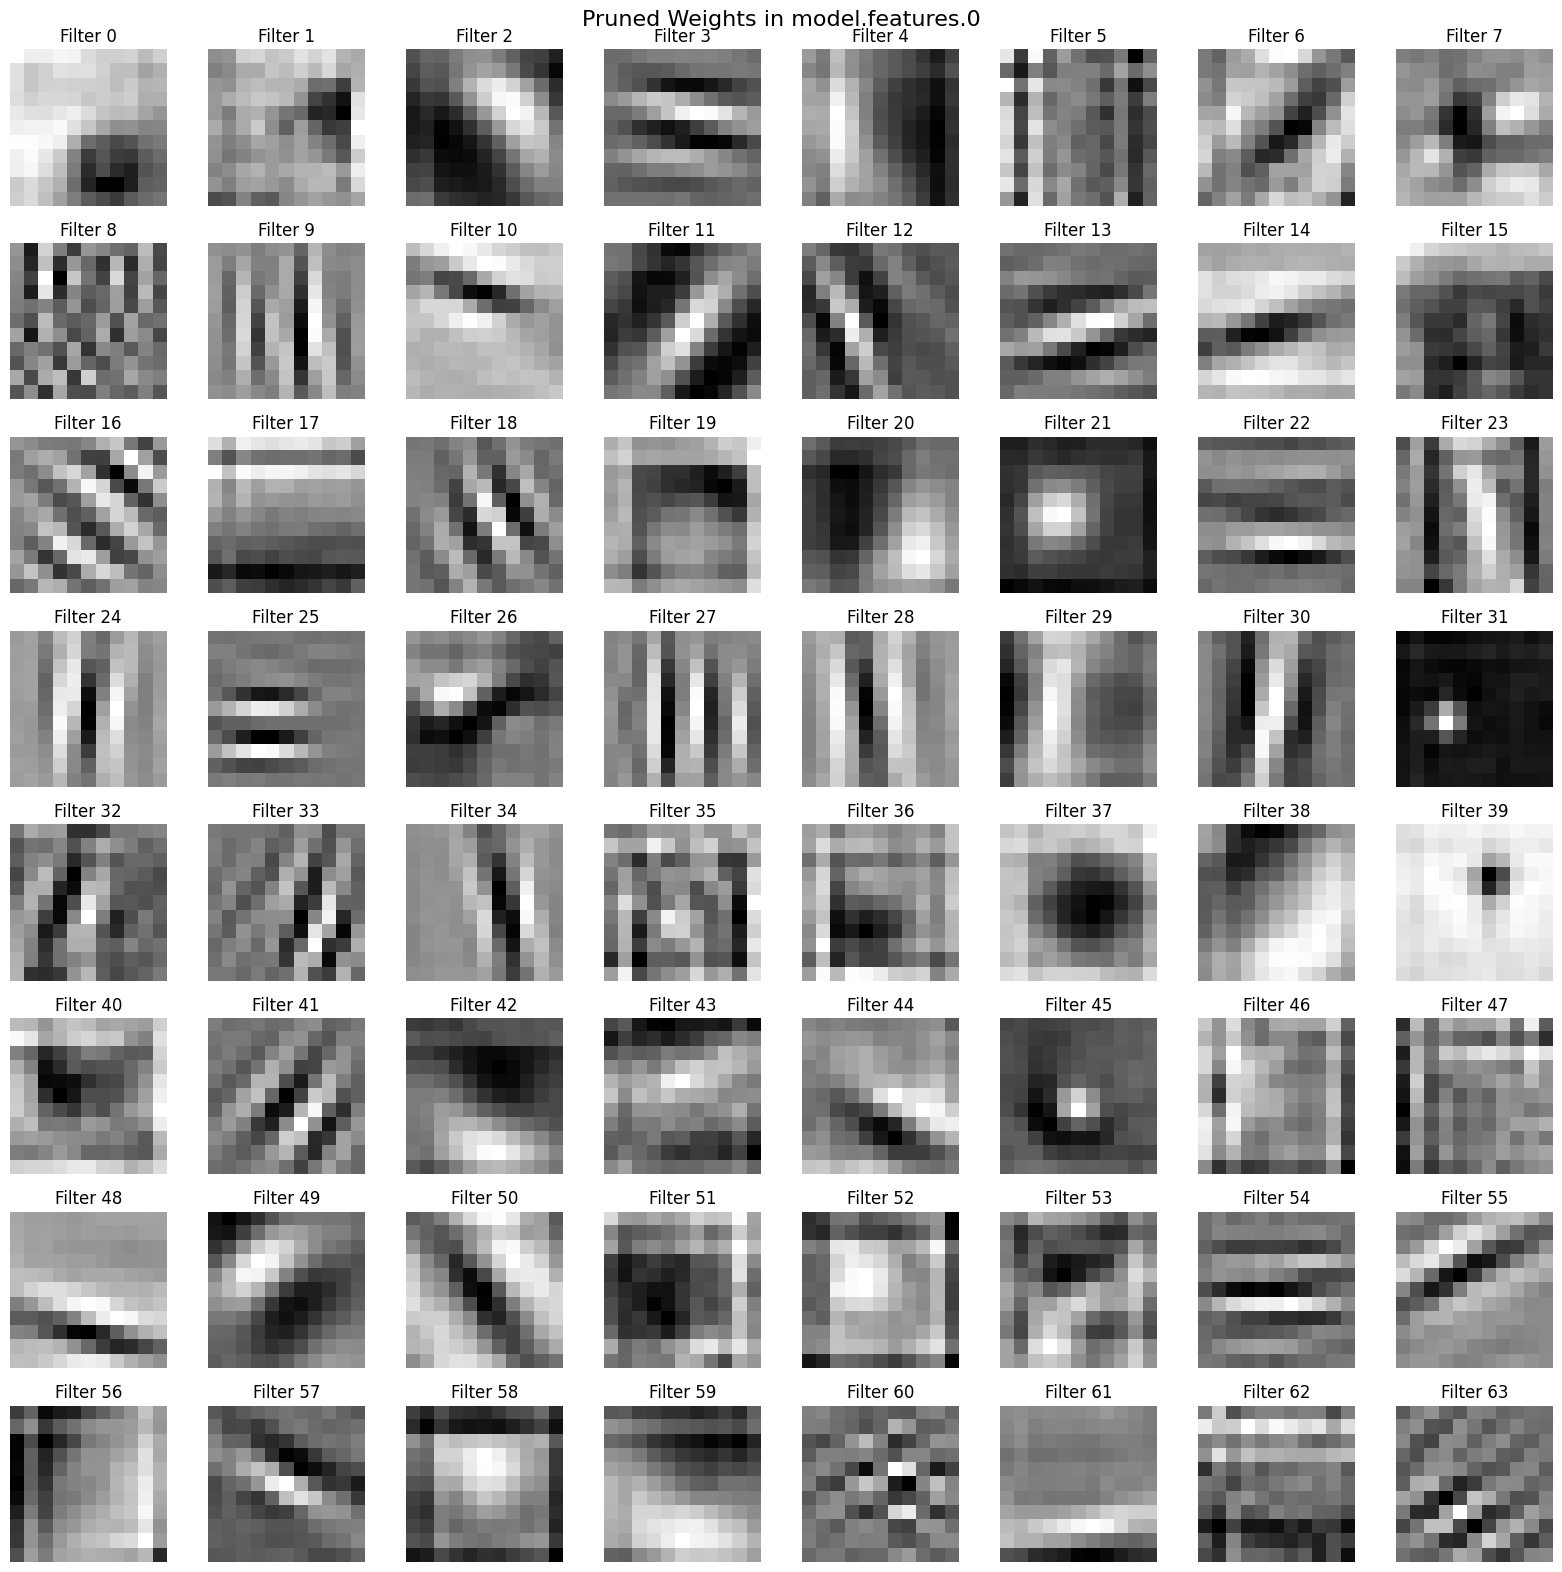

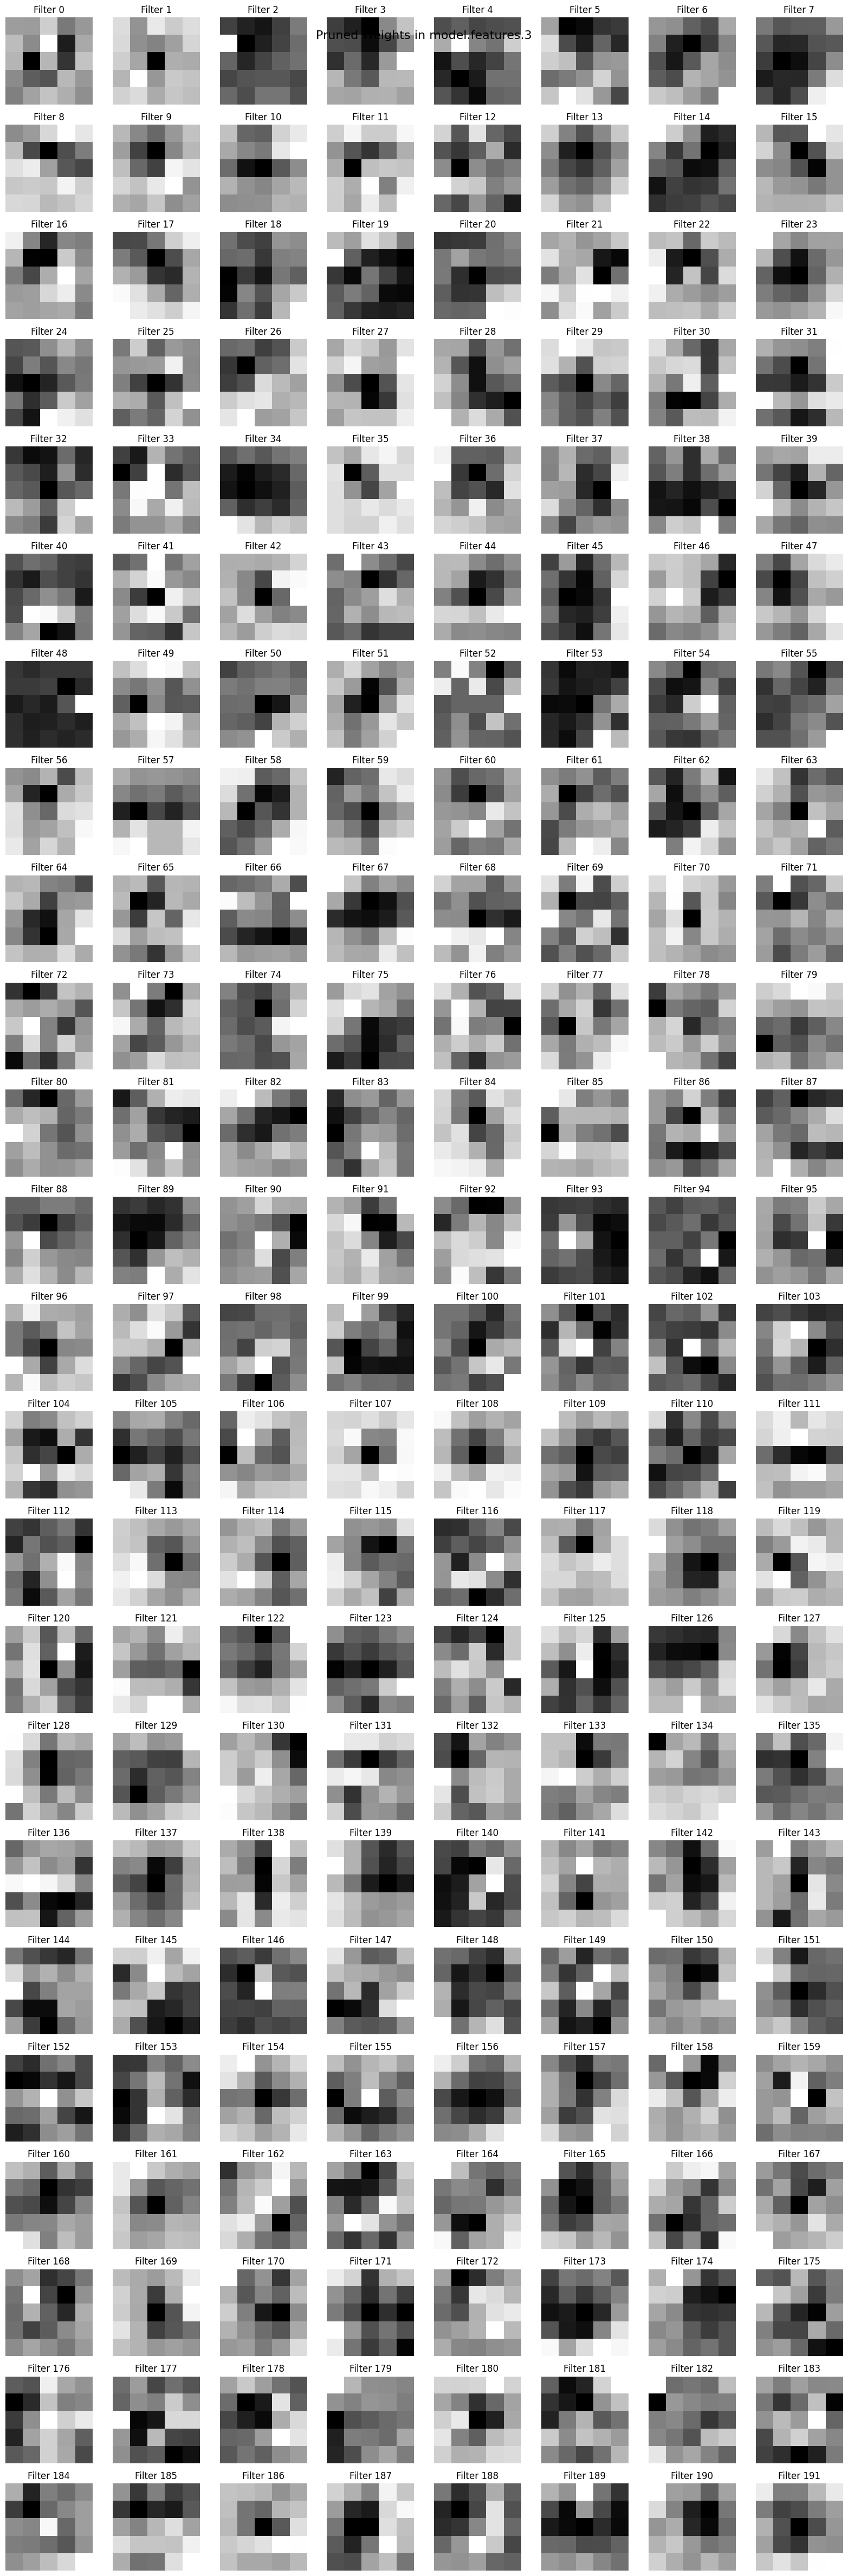

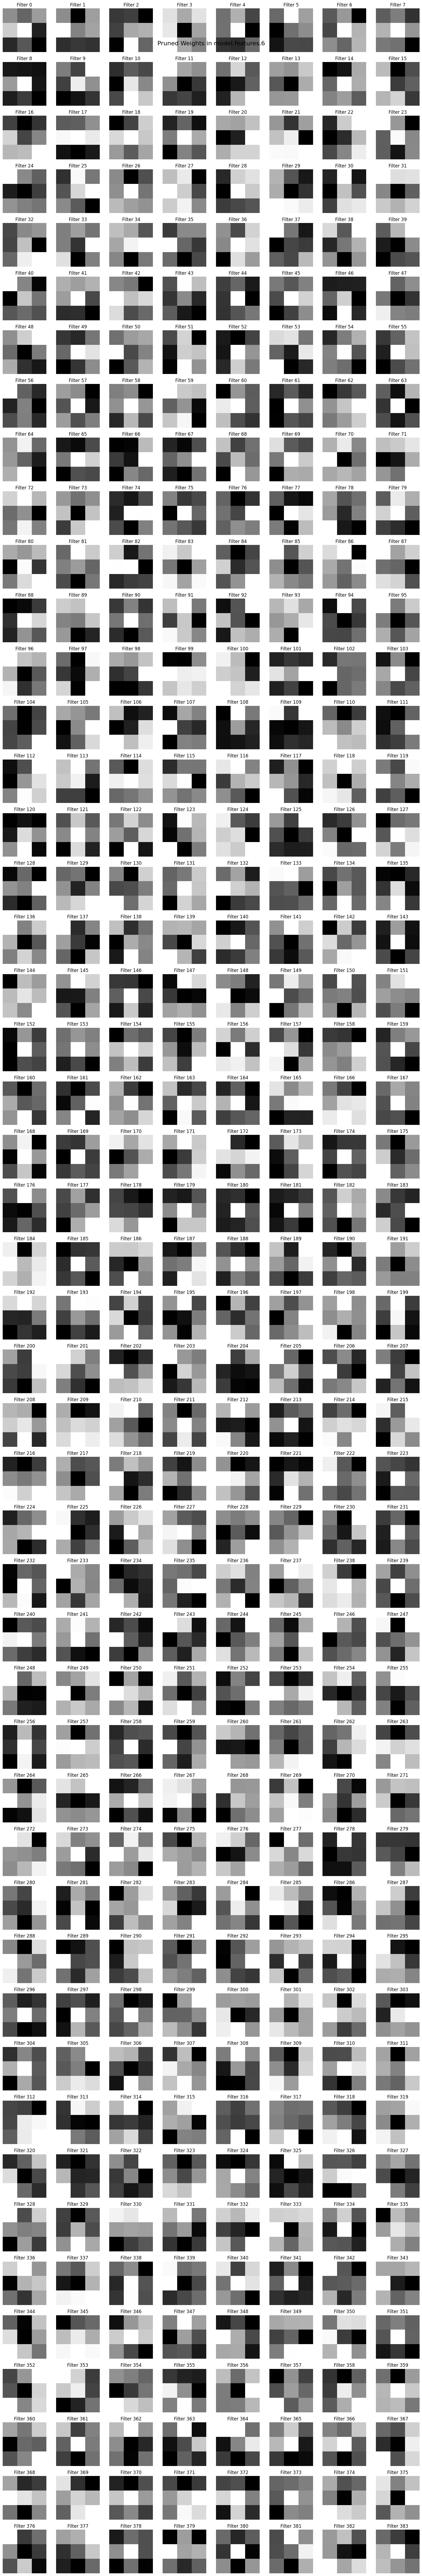

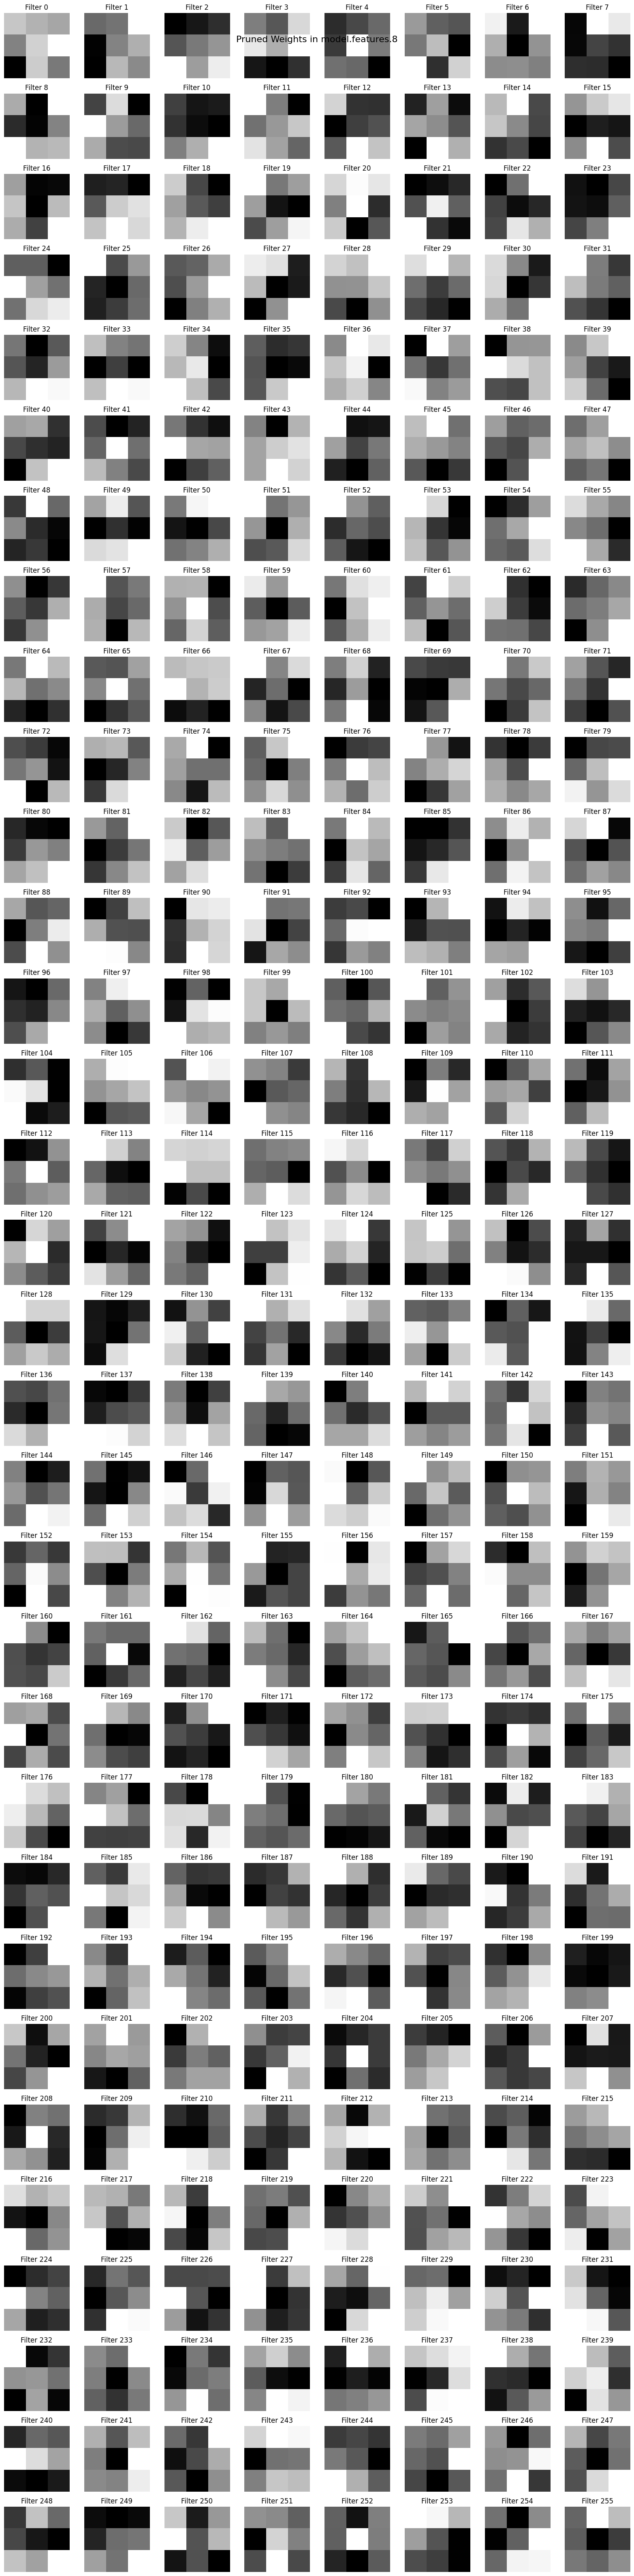

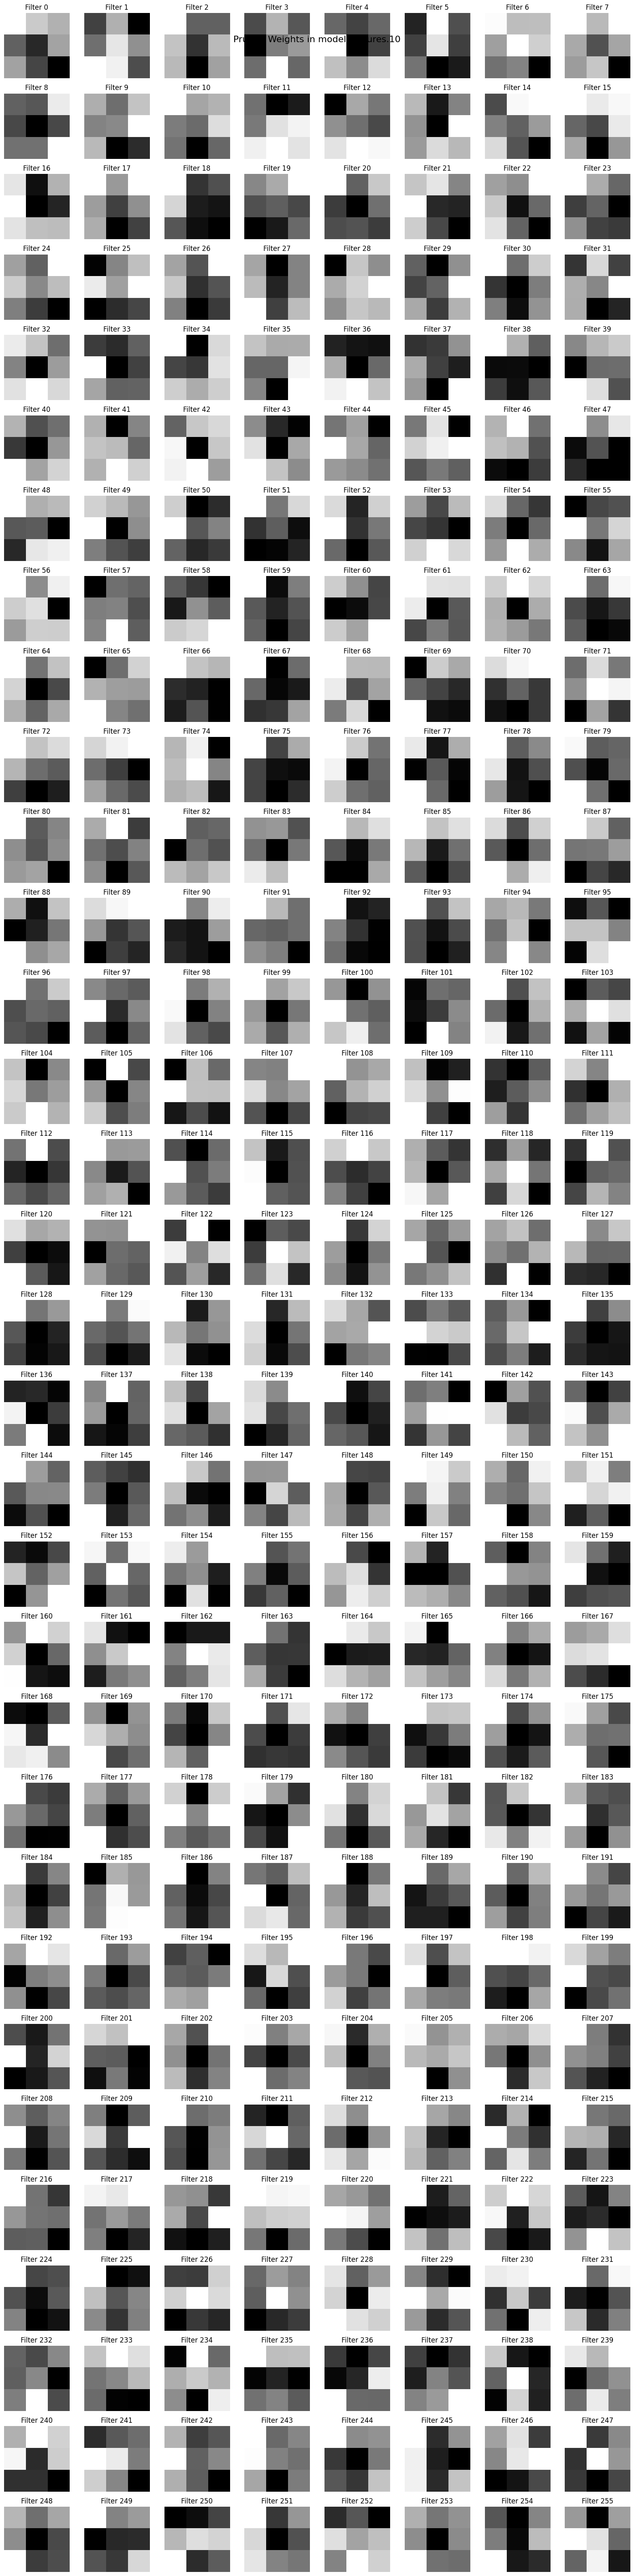

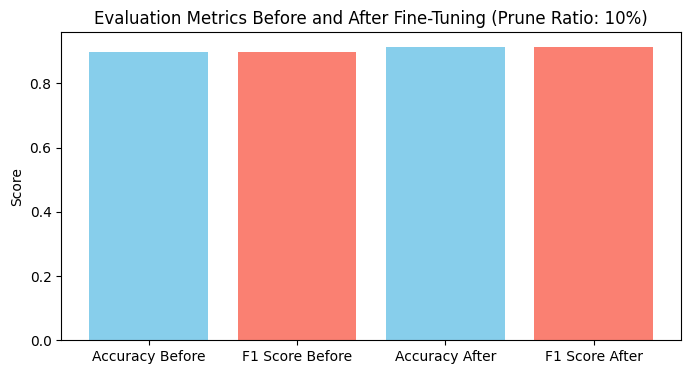

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Original Accuracy before pruning: 0.8985
Original F1 Score before pruning: 0.8983
Fine-tuning the model after pruning 30% of weights...
Epoch 1/3, Train Loss: 299.6245, Train Acc: 0.9163, Val Loss: 55.2359, Val Acc: 0.9417
Epoch 2/3, Train Loss: 176.0344, Train Acc: 0.9526, Val Loss: 54.1862, Val Acc: 0.9411
Epoch 3/3, Train Loss: 112.4840, Train Acc: 0.9727, Val Loss: 54.7447, Val Acc: 0.9394
Fine-tuned Accuracy after pruning 30%: 0.9141
Fine-tuned F1 Score after pruning 30%: 0.9140
Pruned weights visualization saved: ./plots/model_features_0_pruned_weights.png
Pruned weights visualization saved: ./plots/model_features_3_pruned_weights.png
Pruned weights visualization saved: ./plots/model_features_6_pruned_weights.png
Pruned weights visualization saved: ./plots/model_features_8_pruned_weights.png
Pruned weights visualization saved: ./plots/model_features_10_pruned_weights.png
Pruning 30% Complete!


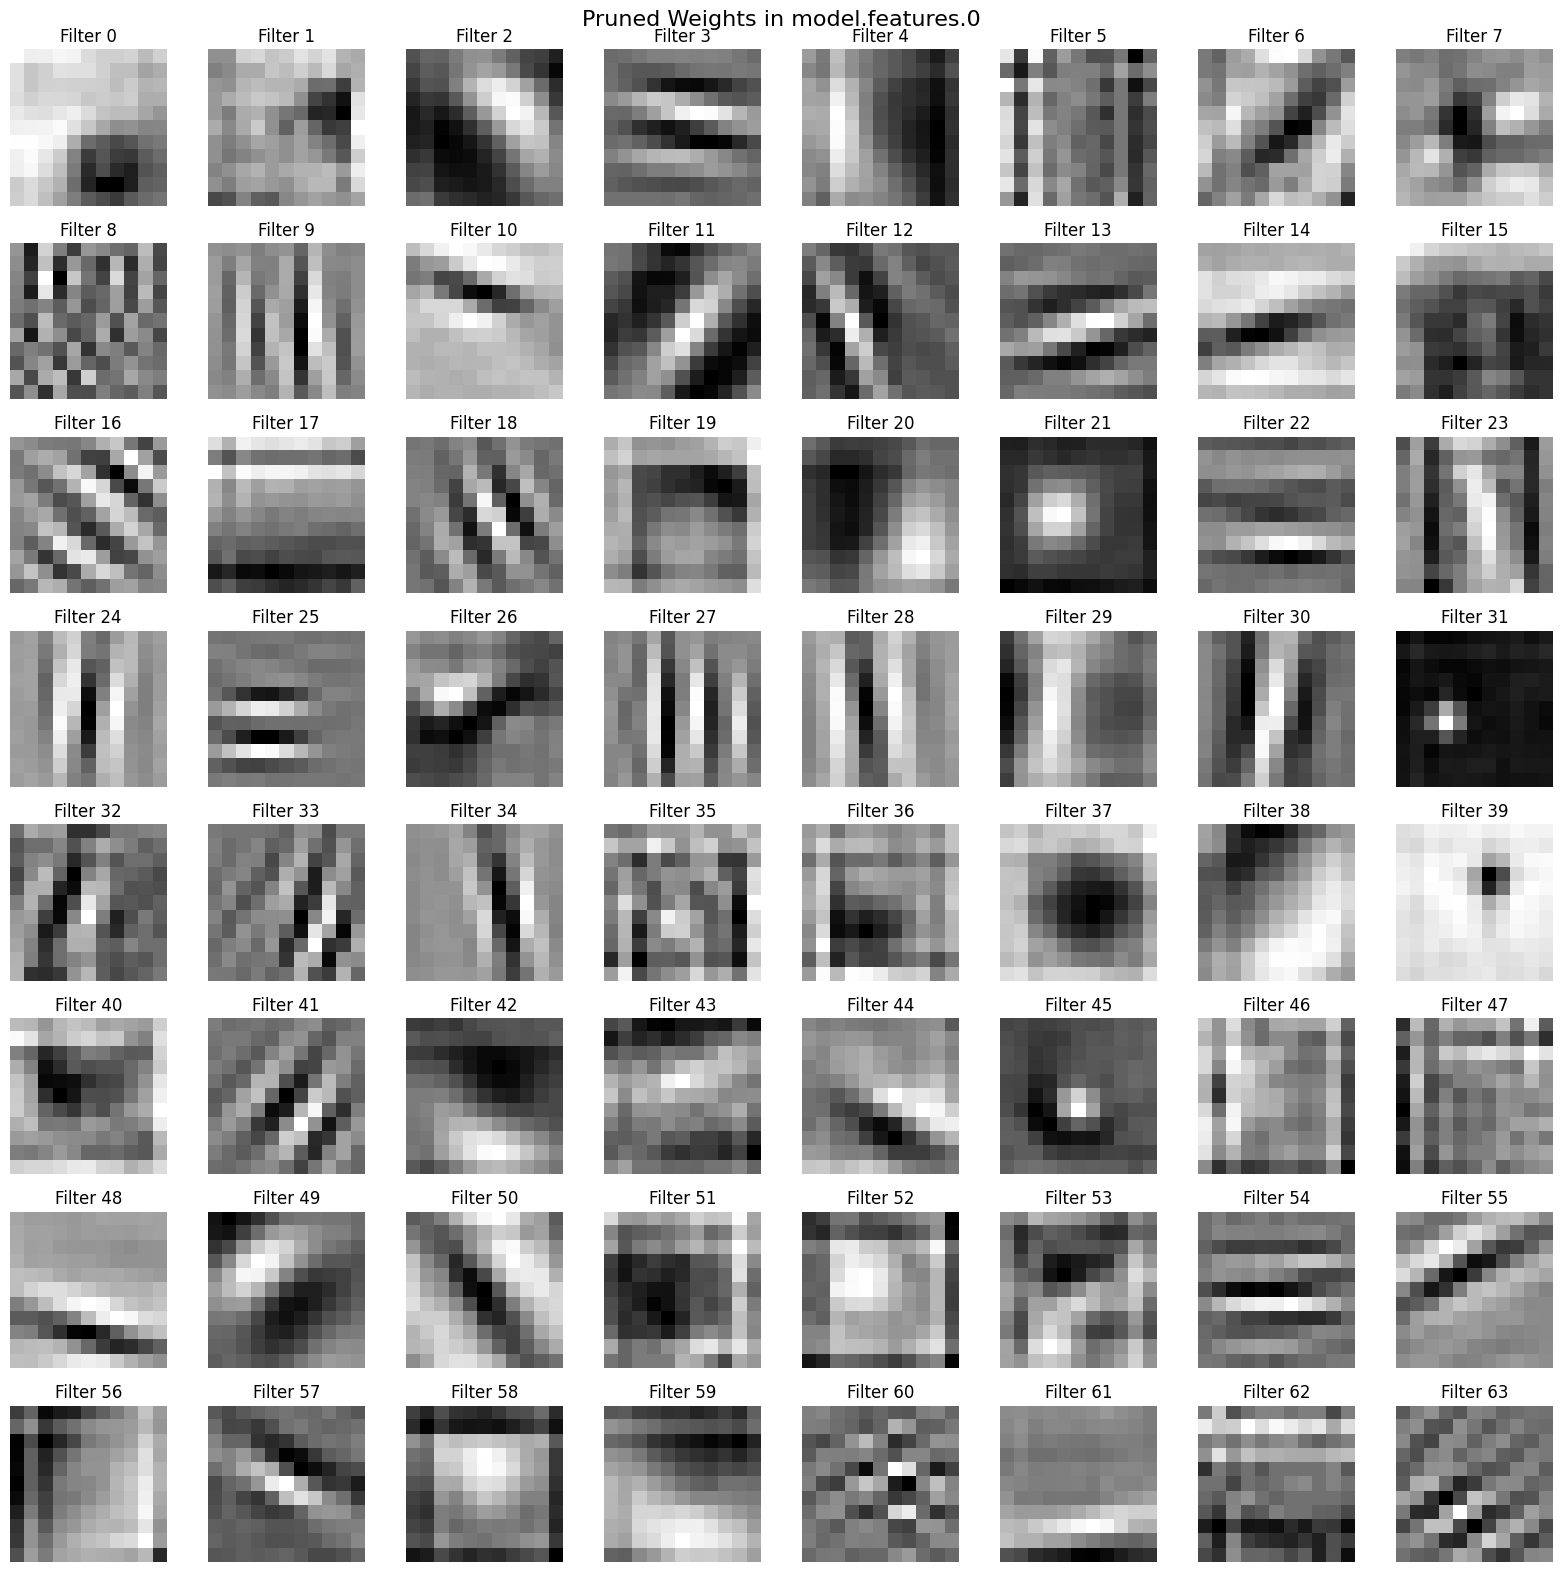

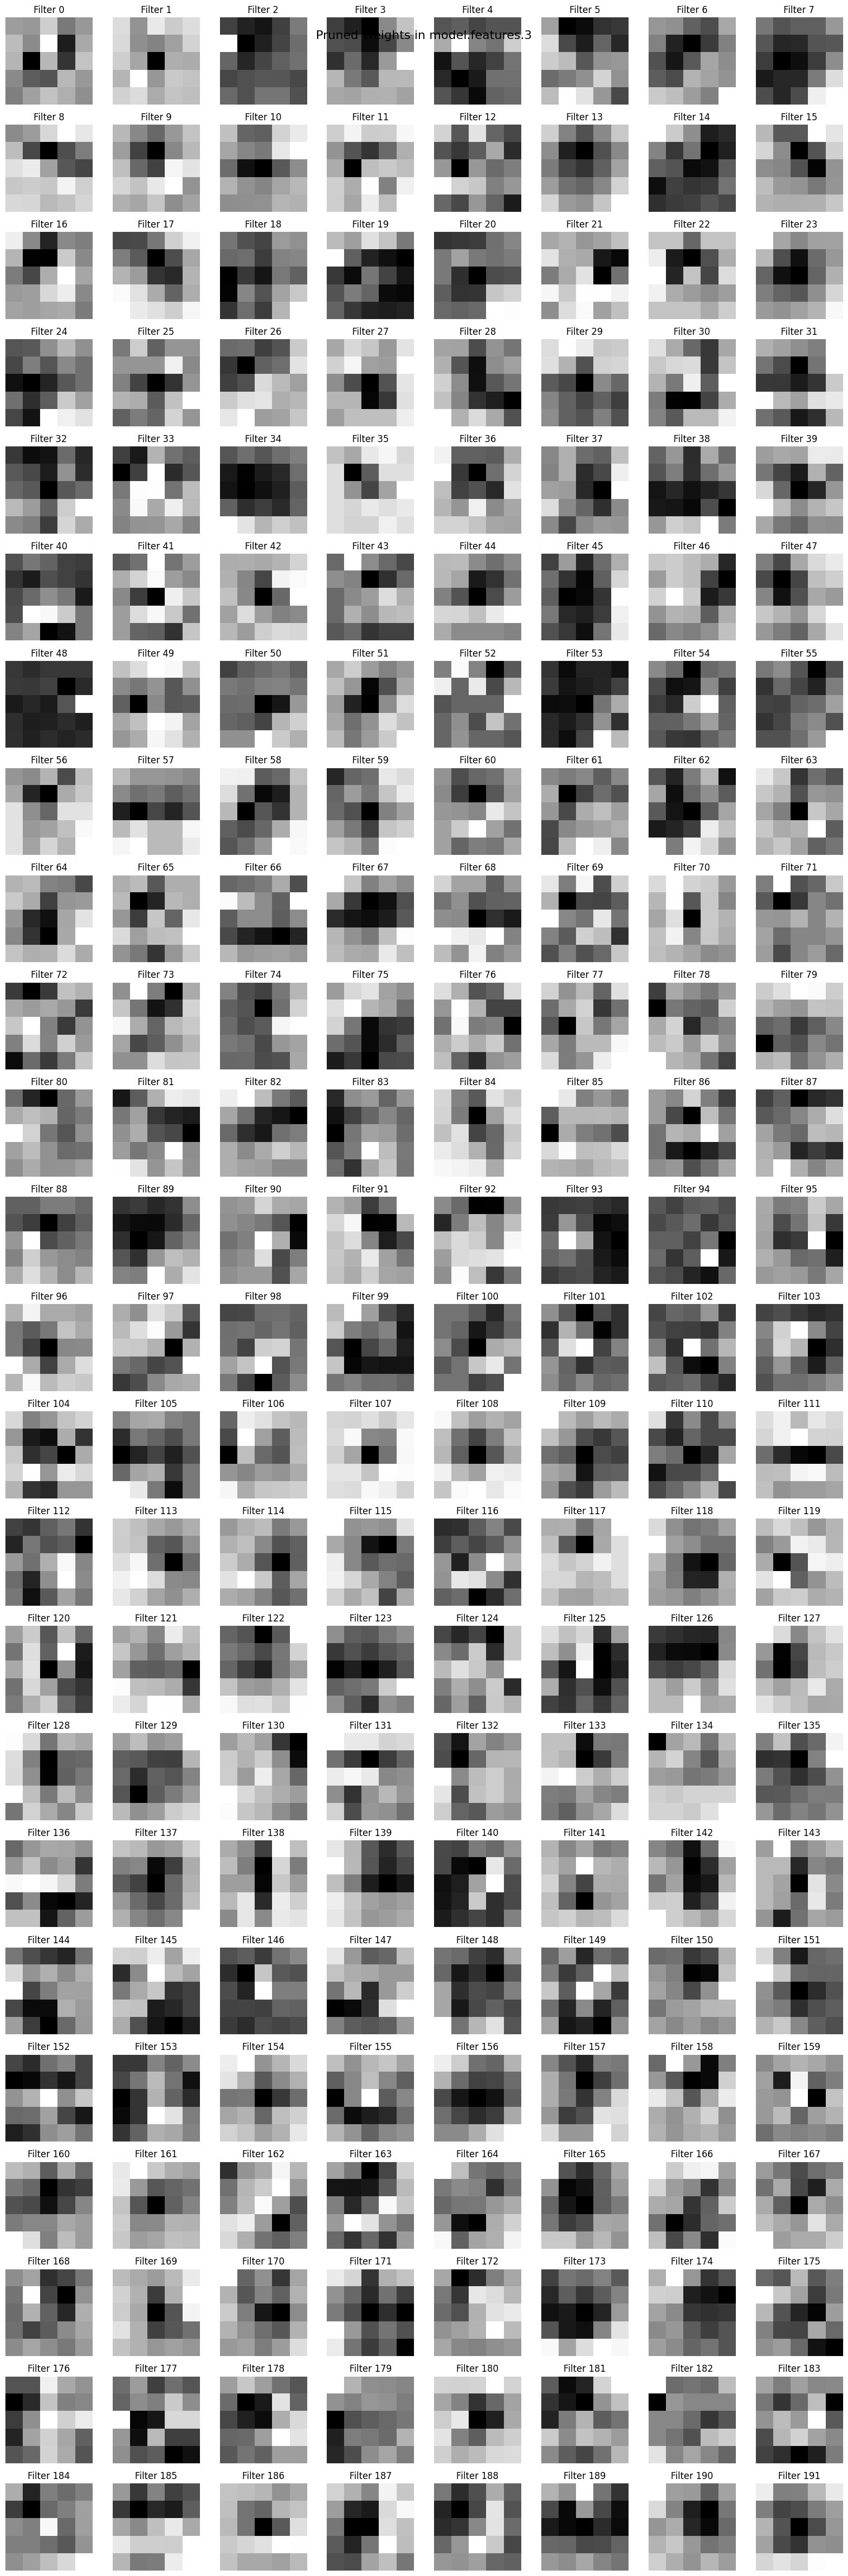

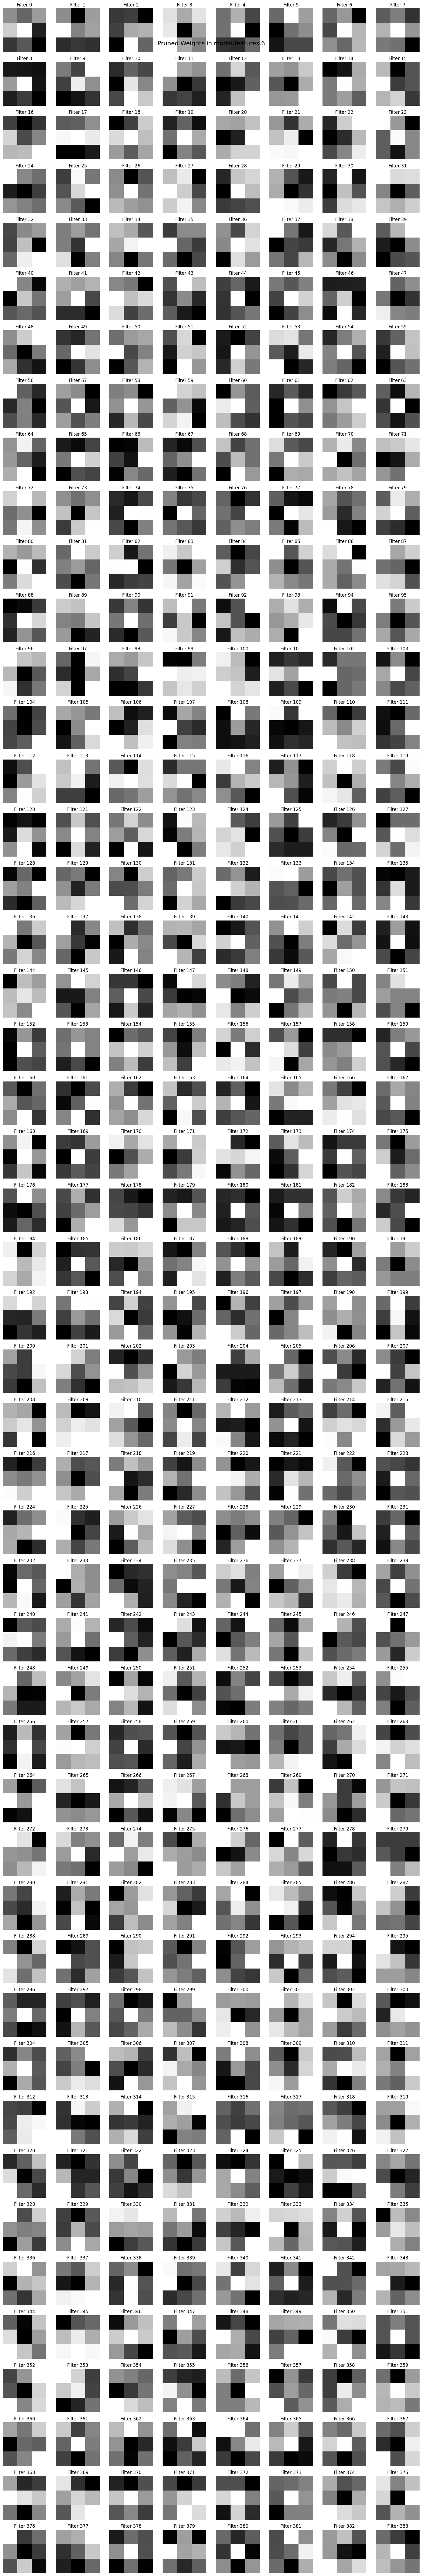

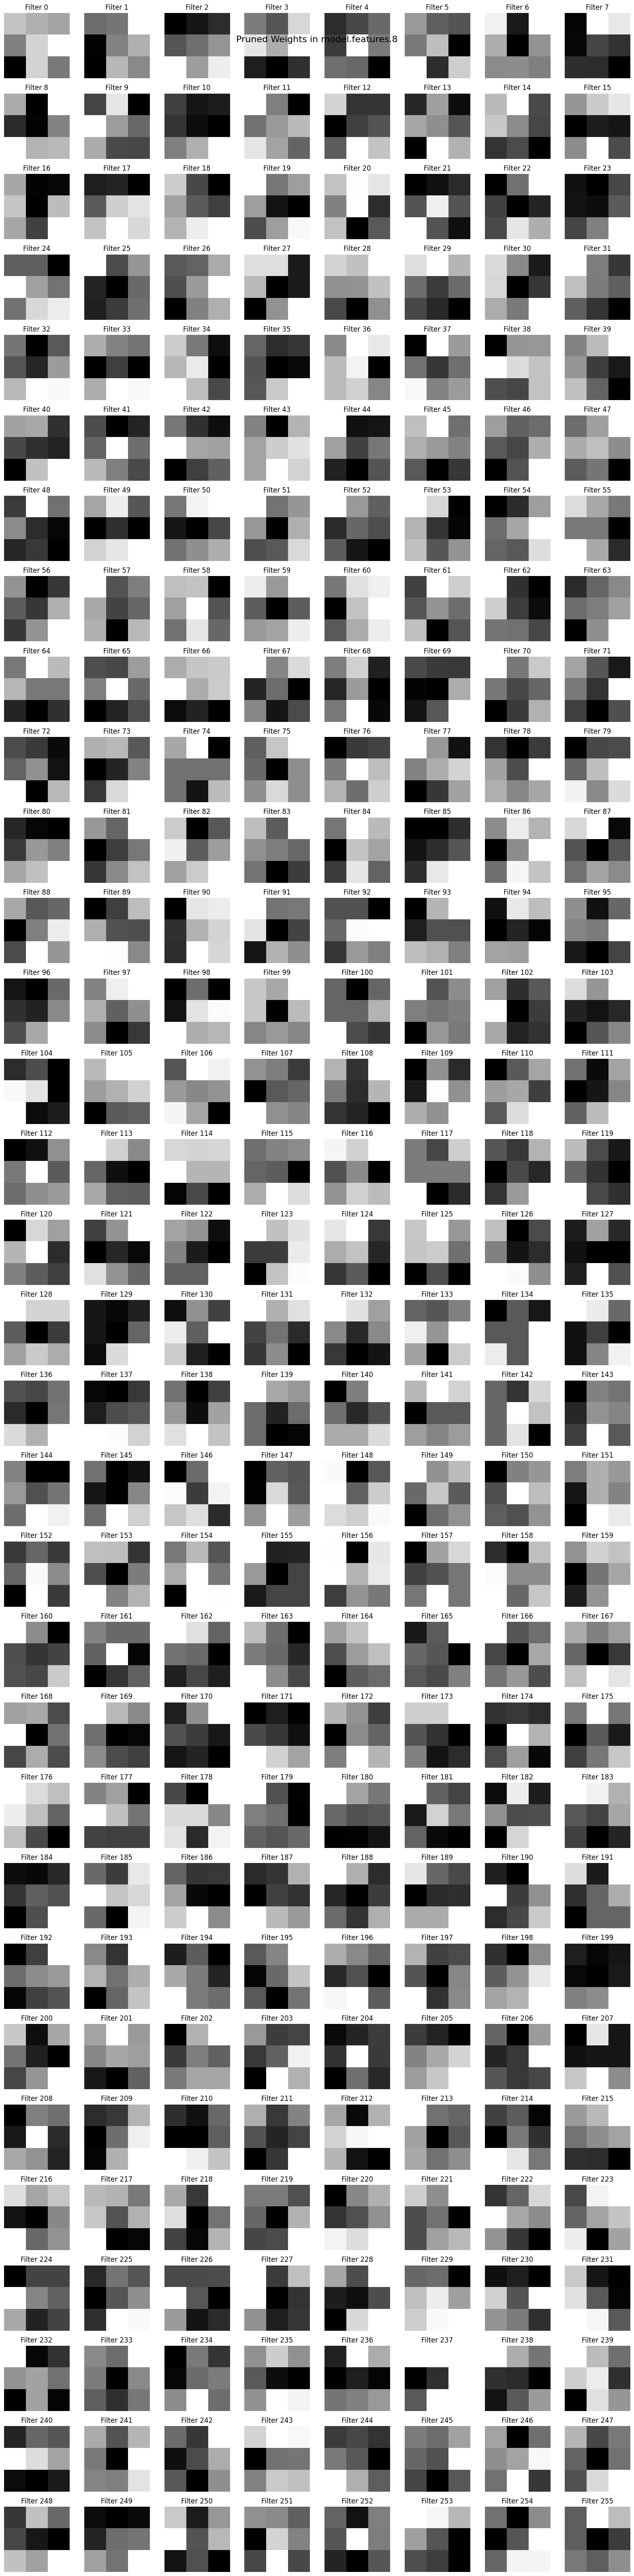

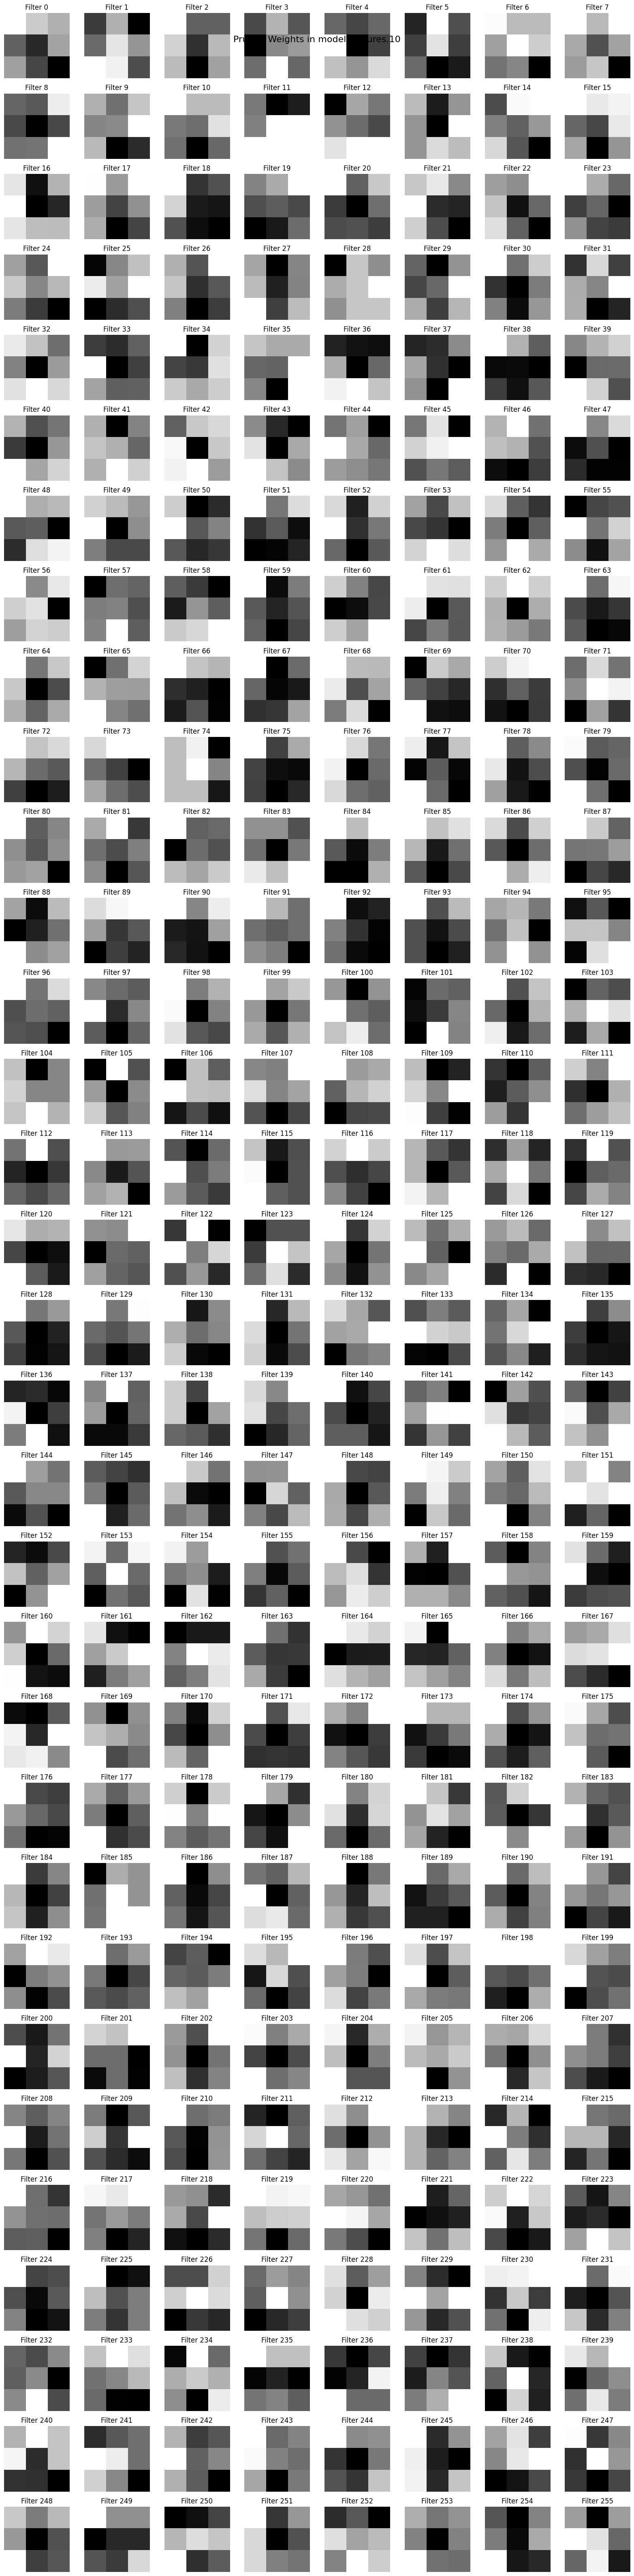

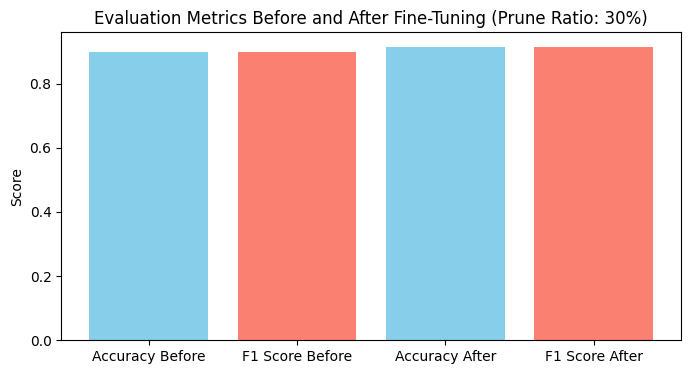

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Original Accuracy before pruning: 0.8985
Original F1 Score before pruning: 0.8983
Fine-tuning the model after pruning 50% of weights...
Epoch 1/3, Train Loss: 307.9922, Train Acc: 0.9149, Val Loss: 57.8698, Val Acc: 0.9374
Epoch 2/3, Train Loss: 190.5244, Train Acc: 0.9483, Val Loss: 54.4598, Val Acc: 0.9392
Epoch 3/3, Train Loss: 134.2723, Train Acc: 0.9655, Val Loss: 56.4154, Val Acc: 0.9369
Fine-tuned Accuracy after pruning 50%: 0.9110
Fine-tuned F1 Score after pruning 50%: 0.9114
Pruned weights visualization saved: ./plots/model_features_0_pruned_weights.png
Pruned weights visualization saved: ./plots/model_features_3_pruned_weights.png
Pruned weights visualization saved: ./plots/model_features_6_pruned_weights.png
Pruned weights visualization saved: ./plots/model_features_8_pruned_weights.png
Pruned weights visualization saved: ./plots/model_features_10_pruned_weights.png
Pruning 50% Complete!


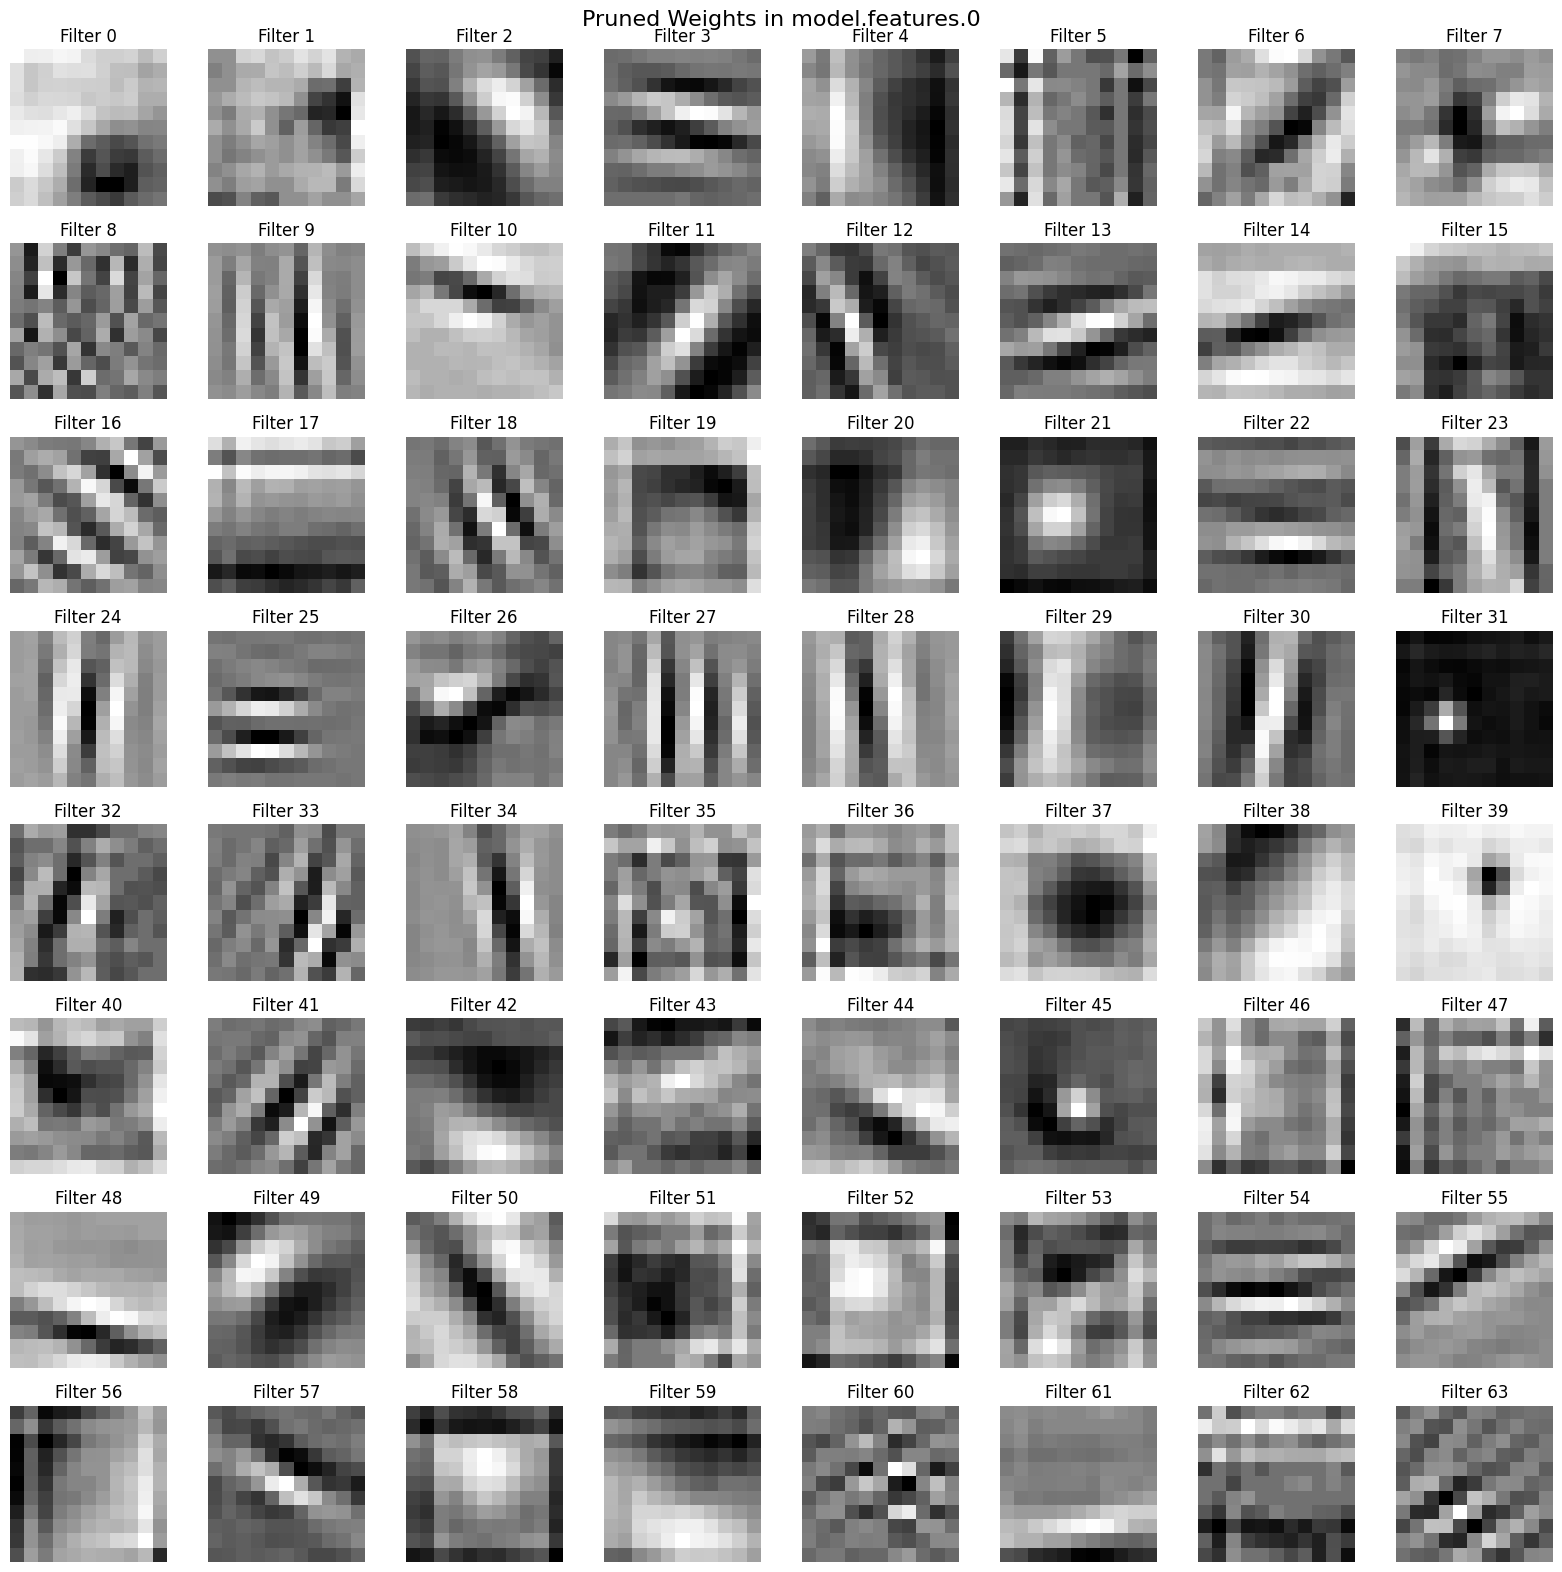

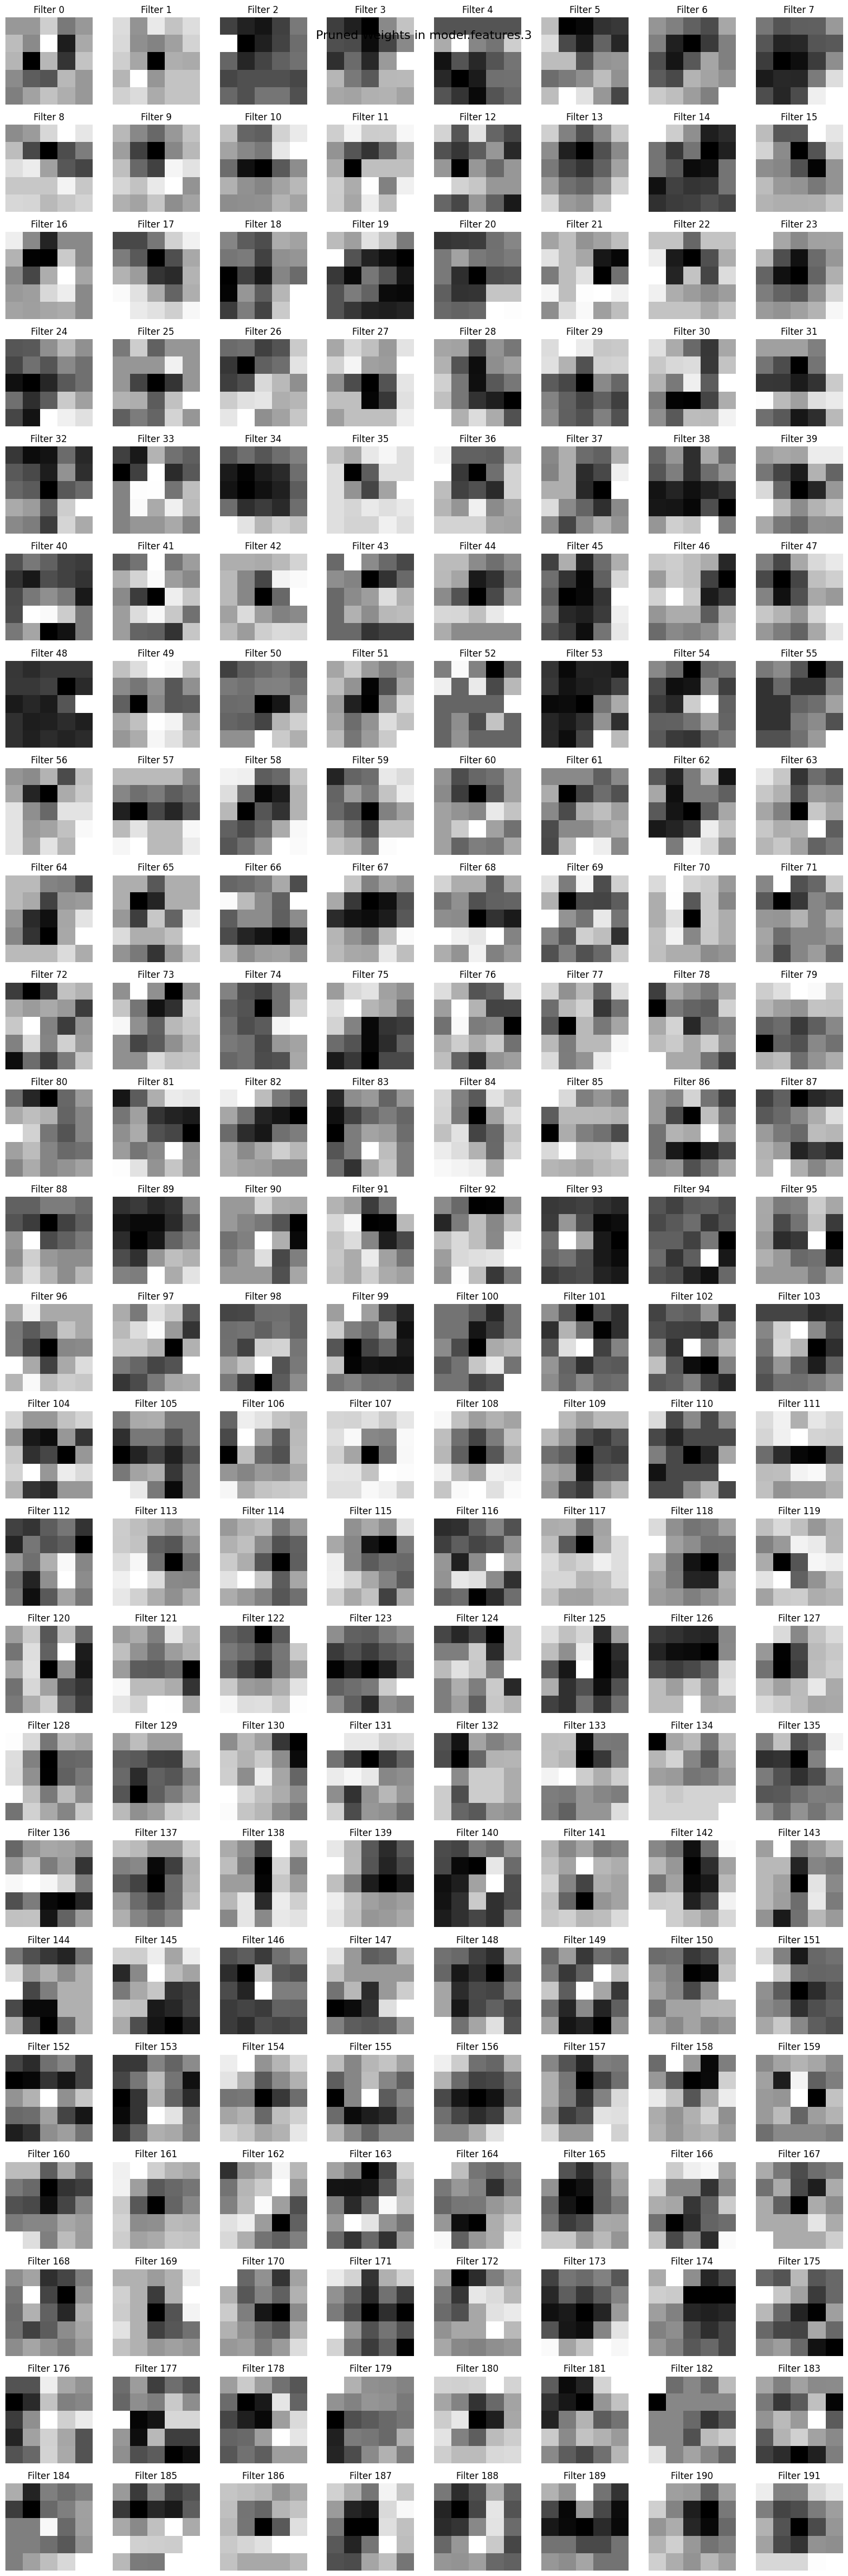

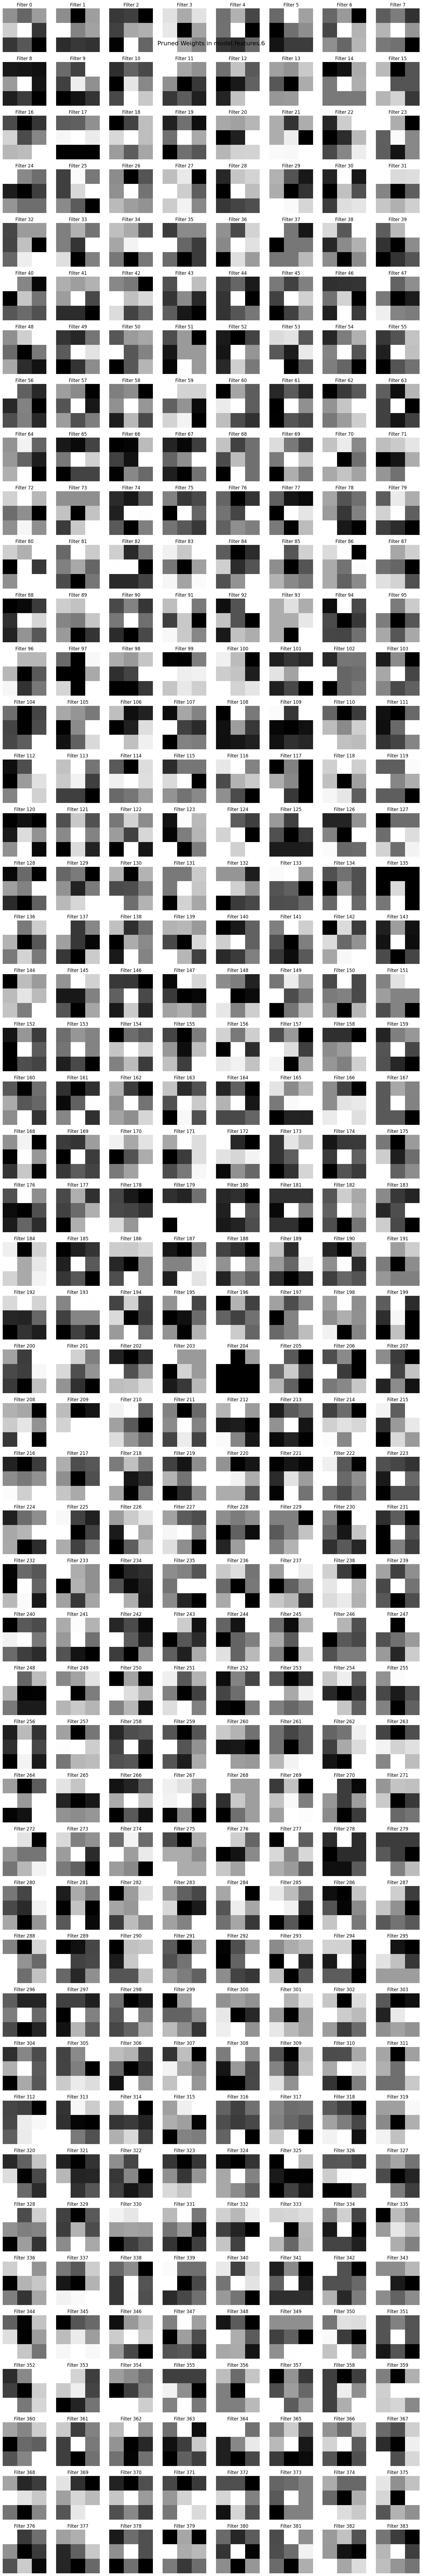

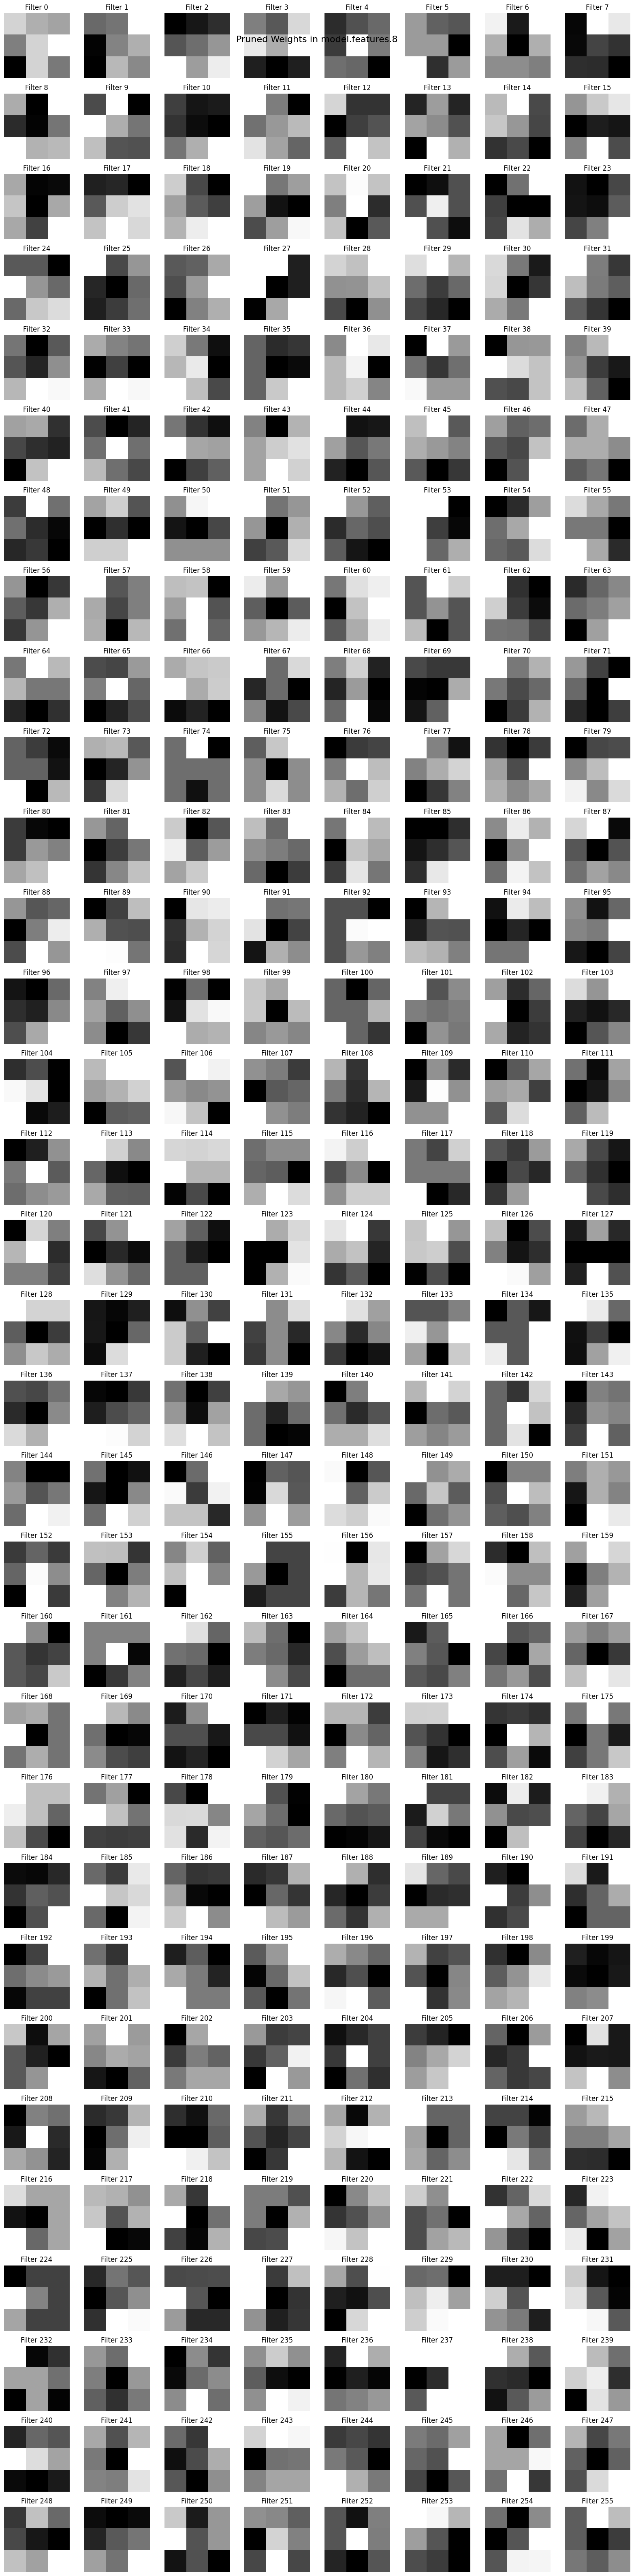

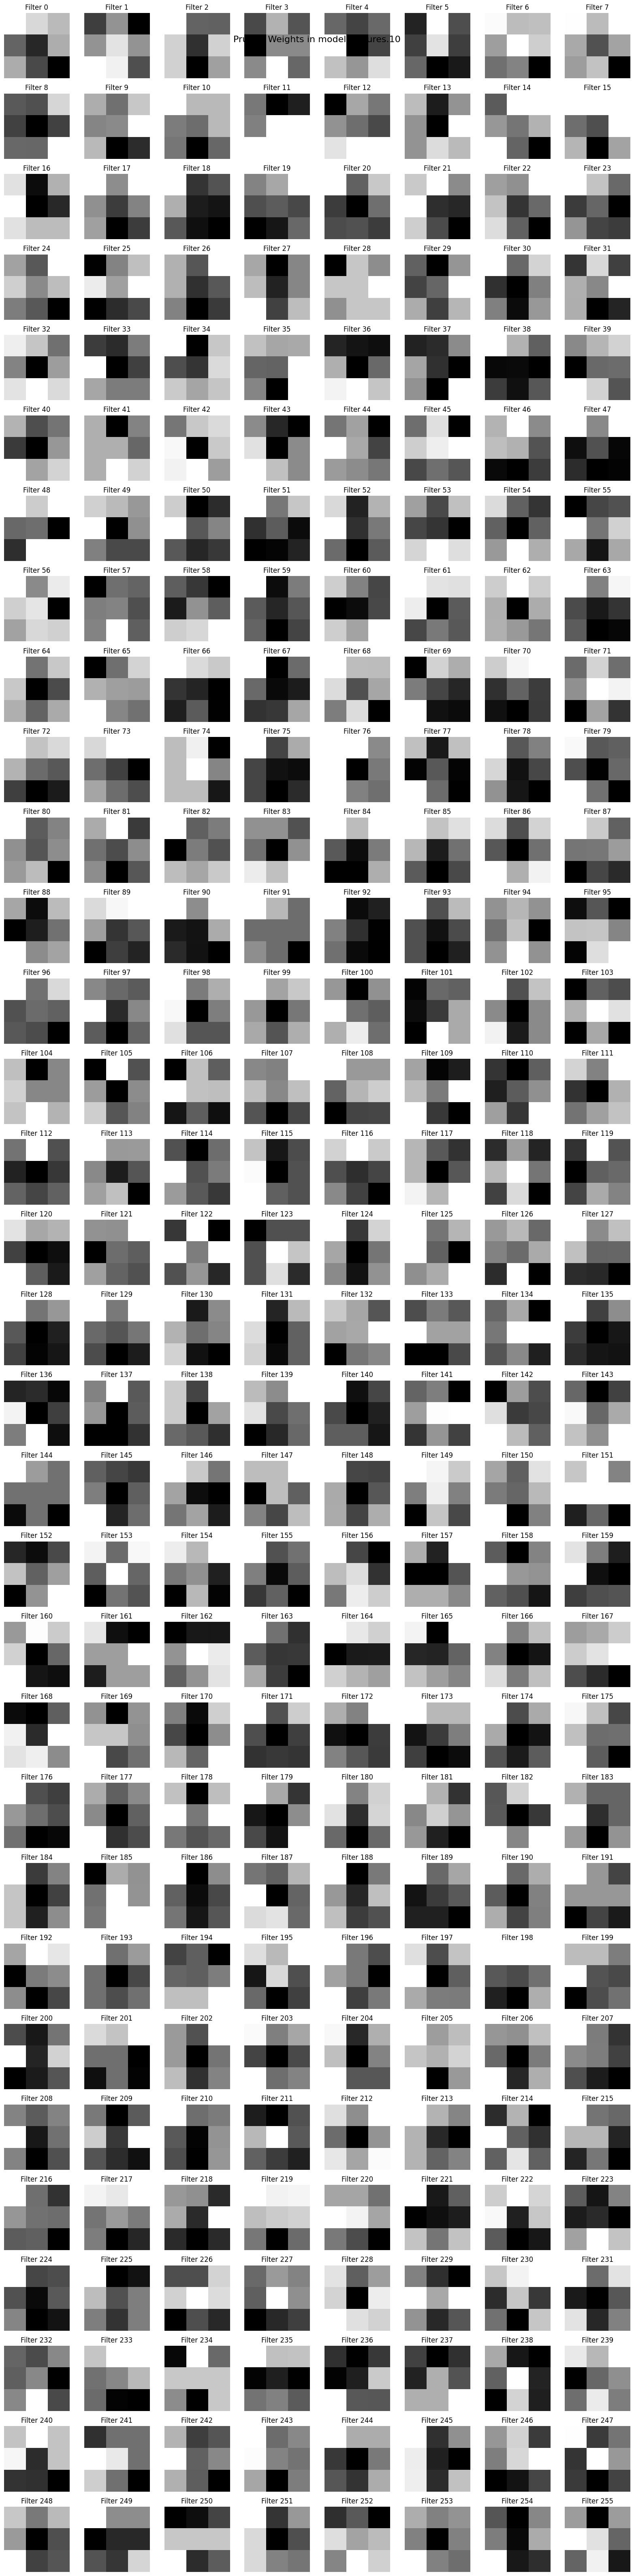

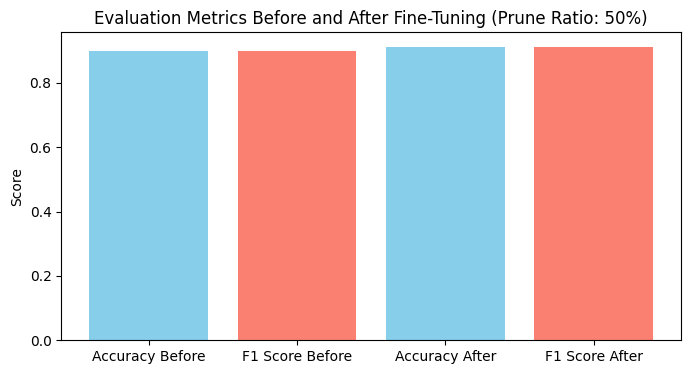

In [7]:
accuracies = []
f1_scores = []

for amount in pruning_percentages:
    checkpoint_path = "../checkpointsAlex/checkpoint_with_aug_epoch5.ckpt"
    model = AlexNetFineTuner.load_from_checkpoint(checkpoint_path).to(device)
    
     # Evaluate the model before pruning
    orig_accuracy, orig_f1_score = evaluate_model(model, test_dataloader)
    print(f"Original Accuracy before pruning: {orig_accuracy:.4f}")
    print(f"Original F1 Score before pruning: {orig_f1_score:.4f}")

    if amount > 0:
        parameters_to_prune = [(module, 'weight') for name, module in model.named_modules() if isinstance(module, (nn.Conv2d, nn.Linear))]
        prune.global_unstructured(parameters_to_prune, pruning_method=prune.L1Unstructured, amount=amount)
    
    print(f"Fine-tuning the model after pruning {amount * 100:.0f}% of weights...")
    fine_tune_model(model, train_dataloader, val_dataloader, epochs=3, learning_rate=1e-5)

    # Evaluate the fine-tuned model
    fine_tuned_accuracy, fine_tuned_f1_score = evaluate_model(model, test_dataloader)
    print(f"Fine-tuned Accuracy after pruning {amount * 100:.0f}%: {fine_tuned_accuracy:.4f}")
    print(f"Fine-tuned F1 Score after pruning {amount * 100:.0f}%: {fine_tuned_f1_score:.4f}")
    
    # Store accuracies and F1 scores for plotting
    accuracies.append((orig_accuracy, fine_tuned_accuracy))
    f1_scores.append((orig_f1_score, fine_tuned_f1_score))
    
    non_zero_indices, new_channels = get_nonzero_indices(model)
    
    for name, module in model.named_modules():
        if isinstance(module, nn.Conv2d):
            visualize_weights(module.weight, f"Pruned Weights in {name}", name=f"{name.replace('.', '_')}_pruned_weights.png")
    
    dense_model = create_dense_model(new_channels)
    copy_weights(model, dense_model, non_zero_indices)

   # Verify the dense model
    print("Original Model:", model)
    print("Dense Model:", dense_model)
    print(f"Pruning {amount * 100:.0f}% Complete!")

    # Plot comparison of accuracy and F1 score before and after fine-tuning
    plot_comparison(
        val_accuracy=orig_accuracy,
        val_f1_score=orig_f1_score,
        fine_tune_accuracy=fine_tuned_accuracy,
        fine_tune_f1_score=fine_tuned_f1_score,
        exp_name=f"Pruning_{amount * 100:.0f}",
        prune_ratio=amount
    )

In [8]:
print("Accuracy for global unstructured", accuracies)

Accuracy for global unstructured [(0.8985, 0.9133), (0.8985, 0.9141), (0.8985, 0.911)]


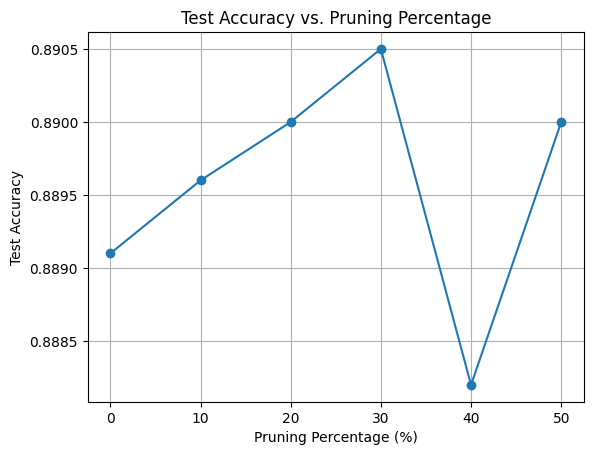

In [8]:
# Plot accuracy vs. pruning percentage
plt.plot([p * 100 for p in pruning_percentages], accuracies, marker='o')
plt.xlabel('Pruning Percentage (%)')
plt.ylabel('Test Accuracy')
plt.title('Test Accuracy vs. Pruning Percentage')
plt.grid(True)
plt.show()